Importy

In [1]:
import numpy as np

from math import log, log2, ceil, pow
from typing import Tuple

Funkcje pomocnicze

In [2]:
def generate_matrix(n_cols: int, n_rows: int):
    # Uniform używa rozkładu jednostajnego ciągłego
    return np.random.uniform(low=0.1, high=0.01, size=(n_rows, n_cols))

In [3]:
generate_matrix(10, 10)

array([[0.04132335, 0.06588616, 0.01876531, 0.01580718, 0.06389306,
        0.09046545, 0.06290329, 0.07862943, 0.01449777, 0.03731174],
       [0.05625217, 0.05074259, 0.02657358, 0.06567922, 0.02504317,
        0.08689055, 0.01472792, 0.06887727, 0.01671878, 0.03736096],
       [0.04484688, 0.07419394, 0.06939691, 0.0452277 , 0.09593462,
        0.05475394, 0.07079886, 0.09212014, 0.03969111, 0.0868644 ],
       [0.07241628, 0.07168676, 0.06438854, 0.02106768, 0.05675493,
        0.07917878, 0.0999414 , 0.04819537, 0.08506623, 0.0787227 ],
       [0.08608096, 0.05435204, 0.07899142, 0.04282656, 0.01550397,
        0.09234168, 0.09057839, 0.01680014, 0.08376537, 0.08408624],
       [0.07362591, 0.02780925, 0.02954509, 0.01334005, 0.03167874,
        0.08311088, 0.05329586, 0.01985239, 0.05101746, 0.02874886],
       [0.01590709, 0.04079248, 0.06821397, 0.07511608, 0.04747576,
        0.09173226, 0.0941165 , 0.09212091, 0.01867446, 0.09203087],
       [0.06992608, 0.0711107 , 0.0857488

In [4]:
class Counter:
    """
    Zliczanie wykonywanych operacji zmiennoprzecinkowych
    """
    def __init__(self) -> None:
        self.operation_counter = 0

    @staticmethod
    def count_operations(func):
        def wrapper(self, *args, **kwargs):
            A, B = args
            self.operation_counter += A.size
            return func(self, *args, **kwargs)
        return wrapper
    
    @count_operations
    def add(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A + B

    @count_operations
    def sub(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A - B

    @count_operations
    def mul(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A * B

    @count_operations
    def div(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A / B

    def print_counts(self) -> None:
        print(f"Number of flops: {self.operation_counter}")

Test

In [5]:
counter = Counter()

result = np.zeros([1, 3])

mat1 = np.array([1, 2, 3])
mat2 = np.array([1, 2, 3])
print(mat1)
print(mat2)

result += counter.add(mat1, mat2)

[1 2 3]
[1 2 3]


In [6]:
counter.print_counts()
print(result)

Number of flops: 3
[[2. 4. 6.]]


Funkcje pomocnicze

In [7]:
def resize_matrix_to_2n(A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Zmiana wielkości macierzy
    """
    size_A: Tuple[int, int] = A.shape
    size_B: Tuple[int, int] = B.shape
    new_height: int = 0
    new_width: int = 0

    # Height
    if size_A[0] > size_B[0]:
        new_height = find_next_power_of_2(size_A[0])
    else:
        new_height = find_next_power_of_2(size_B[0])

    # Width
    if size_A[1] > size_B[1]:
        new_width = find_next_power_of_2(size_A[1])
    else:
        new_width = find_next_power_of_2(size_B[1])

    # Wypełnienie zerami
    new_A = np.pad(
        A, [(0, new_height - size_A[0]), (0, new_width - size_A[1])], mode="constant"
    )
    new_B = np.pad(
        B, [(0, new_height - size_B[0]), (0, new_width - size_B[1])], mode="constant"
    )
    return new_A, new_B

def split(array: np.ndarray, n_rows: int, n_cols: int) -> Tuple:
    """Split a matrix into sub-matrices"""
    r, h = array.shape
    return (
        array.reshape(h // n_rows, n_rows, -1, n_cols)
        .swapaxes(1, 2)
        .reshape(-1, n_rows, n_cols)
    )

def find_next_power_of_2(number: int) -> int:
    """
    Szukiwanie kolejnej potęgi 2
    """
    return 1 if number == 0 else 2 ** ceil(log2(number))

Algorytm Bineta

In [8]:
def binet_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    mul = counter.mul
    
    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)

        C11 = add(
            binet_core_algorithm(A11, B11, counter),
            binet_core_algorithm(A12, B21, counter),
        )
        C12 = add(
            binet_core_algorithm(A11, B12, counter),
            binet_core_algorithm(A12, B22, counter),
        )     
        C21 = add(
            binet_core_algorithm(A21, B11, counter),
            binet_core_algorithm(A22, B21, counter),
        )
        
        C22 = add(
            binet_core_algorithm(A21, B12, counter),
            binet_core_algorithm(A22, B22, counter),
        )

        return np.concatenate(
            [np.concatenate([C11, C12], axis=1), np.concatenate([C21, C22], axis=1)],
            axis=0,
        )
    
    else:
        return mul(A, B)

def binet_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = binet_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C
    

Test algorytmu Bineta

In [9]:
A = generate_matrix(5, 5)
B = generate_matrix(5, 5)

print(A)
print(B)

counter = Counter()

result_binet = binet_algorithm(A, B, counter)
result_numpy = A @ B

print(result_binet)
print(result_numpy)

print(f"Are the results close: {np.allclose(result_binet, result_numpy)}")

[[0.06640514 0.05249428 0.0314382  0.04198953 0.08594552]
 [0.03481166 0.0423851  0.05213835 0.08932538 0.04952694]
 [0.03795679 0.01475571 0.04705604 0.02329706 0.05687859]
 [0.07596362 0.06139945 0.01276509 0.06261145 0.07987313]
 [0.07068266 0.08331874 0.05235578 0.06951084 0.05194275]]
[[0.01214035 0.02676038 0.02033435 0.03656443 0.01924569]
 [0.0293678  0.04845406 0.07266996 0.0917358  0.04092064]
 [0.01710143 0.06196731 0.04764699 0.07110897 0.08393004]
 [0.08671476 0.03420047 0.08781452 0.08625703 0.02376019]
 [0.09570352 0.08260765 0.03129657 0.04520934 0.07966271]]
[[0.01475186 0.01480455 0.01304009 0.01698664 0.01390905]
 [0.01504475 0.01336245 0.01566632 0.01881263 0.01284821]
 [0.00916256 0.01014203 0.00791213 0.01066858 0.01036838]
 [0.01601717 0.01453836 0.01461273 0.0183295  0.01289642]
 [0.01519908 0.01584114 0.01771634 0.02229484 0.01495351]]
[[0.01475186 0.01480455 0.01304009 0.01698664 0.01390905]
 [0.01504475 0.01336245 0.01566632 0.01881263 0.01284821]
 [0.0091625

Algorytm Strassena

In [10]:
def strassen_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    sub = counter.sub
    mul = counter.mul

    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)

        P1 = strassen_core_algorithm(add(A11, A22), add(B11, B22), counter)
        P2 = strassen_core_algorithm(add(A21, A22), B11, counter)
        P3 = strassen_core_algorithm(A11, sub(B12, B22), counter)
        P4 = strassen_core_algorithm(A22, sub(B21, B11), counter)
        P5 = strassen_core_algorithm(add(A11, A12), B22, counter)
        P6 = strassen_core_algorithm(sub(A21, A11), add(B11, B12), counter)
        P7 = strassen_core_algorithm(sub(A12, A22), add(B21, B22), counter)

        C11 = add(sub(add(P1, P4), P5), P7)
        C12 = add(P3, P5)
        C21 = add(P2, P4)
        C22 = add(add(sub(P1, P2), P3), P6)

        return np.concatenate(
                    [np.concatenate([C11, C12], axis=1), np.concatenate([C21, C22], axis=1)],
                    axis=0,
                )
    else:
        return mul(A, B)

def strassen_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = strassen_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C
    

Test algorytmu Strassena

In [11]:
A = generate_matrix(2, 2)
B = generate_matrix(2, 2)

print(A)
print(B)

counter = Counter()

result_strassen = strassen_algorithm(A, B, counter)
result_numpy = A @ B

print(result_strassen)
print(result_numpy)

print(f"Are the results close: {np.allclose(result_strassen, result_numpy)}")

counter.print_counts()

[[0.04458269 0.06709379]
 [0.03101933 0.0249647 ]]
[[0.04116296 0.02300467]
 [0.040042   0.04166482]]
[[0.00452173 0.00382106]
 [0.00227648 0.00175374]]
[[0.00452173 0.00382106]
 [0.00227648 0.00175374]]
Are the results close: True
Number of flops: 25


In [12]:
import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import FormatStrFormatter
from typing import List

times_binet: List[float] = []
flops_binet: List[int] = []

power_basis = list(range(2, 9))
powers = [2**k for k in power_basis]

for k in power_basis:
    A = np.random.rand(2**k, 2**k)
    B = np.random.rand(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    binet_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_binet.append(total_time)
    flops_binet.append(counter.print_counts)

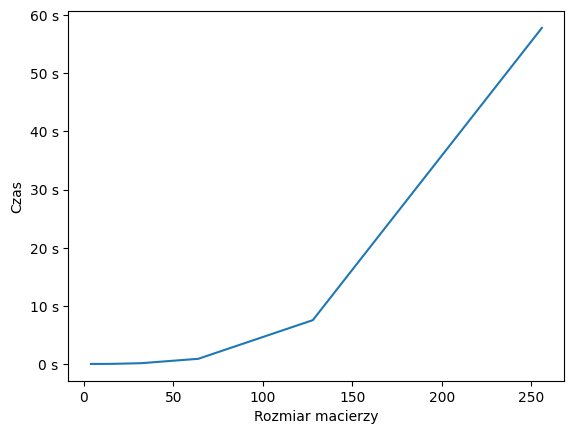

In [13]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_binet)

In [43]:
times_strassen: List[float] = []
flops_strassen: List[int] = []

for k in power_basis:
    A = np.random.rand(2**k, 2**k)
    B = np.random.rand(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    strassen_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_strassen.append(total_time)
    flops_strassen.append(counter.print_counts)

KeyboardInterrupt: 

In [ ]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_strassen)

In [ ]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_strassen)